# How do you find an optimal K for a K-Means cluster?

Matthew Kirk

This notebook outlines a possible method of utilizing information bottleneck theory to find an optimal K. The general idea is that information bottleneck which minimizes I(X;T) - \beta I(T;Y) can be used for ideas that aren't just deep learning.

What we start with is the IRIS dataset, run K-Means on it with various K values and then graphically see if we can find an optimal K.

In [326]:
# This first section we will load up the IRIS dataset and import packages
# If you are having trouble getting this running I recommend installing Anaconda.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import mutual_info_score

import seaborn as sns

import pandas as pd

np.random.seed(42)

iris = datasets.load_iris()

X = iris.data
y = iris.target

In [327]:
# Scikit learn doesn't have a matrix mutual information score so this creates that function.

def matrixize(m):
    if len(m.shape) < 2:
        return np.asarray(np.matrix(m).transpose())
    else:
        return m
        
def mutual_info_matrix(X, Y):
    # X takes the shape of rows x features
     
    x_mat = matrixize(X)
    y_mat = matrixize(Y)
    
    f = x_mat.shape[1]
    y = y_mat.shape[1]
    
    mi_matrix = np.zeros((f, y))
    
    for i in range(f):
        for j in range(y):
            mi_matrix[i][j] = mutual_info_score(x_mat[:, i], y_mat[:, j])
    
    return mi_matrix

In [328]:
# Since the IRIS dataset is only about 150 instances long clusters of size 2 - 30 should be sufficient.
# We probably won't want K=2 and K=30 but somewhere between.

rows = []
for k in range(2, 30):
    est = KMeans(n_clusters=k)

    est.fit(X)
    labels = est.labels_
    
    row = {'k': k, 'I(l; y)': mutual_info_score(labels, y)}
    
    xes = mutual_info_matrix(X, labels)
    xes = {'I(x_{}; l)'.format(i): v[0] for i, v in enumerate(xes)}
    
    row = {**row, **xes}
    
    rows.append(row)
    
df = pd.DataFrame(rows)

This next section will show the mutual information of each dimension and the labels (created by the K-Means clusterer) as well as the mutual information from the labels to the output Y.

What this shows is fascinating since using a lowess regression you can see an obvious _phase shift_ around k=12. This is the information bottleneck happening in practice. We are seeing noise turn into information!

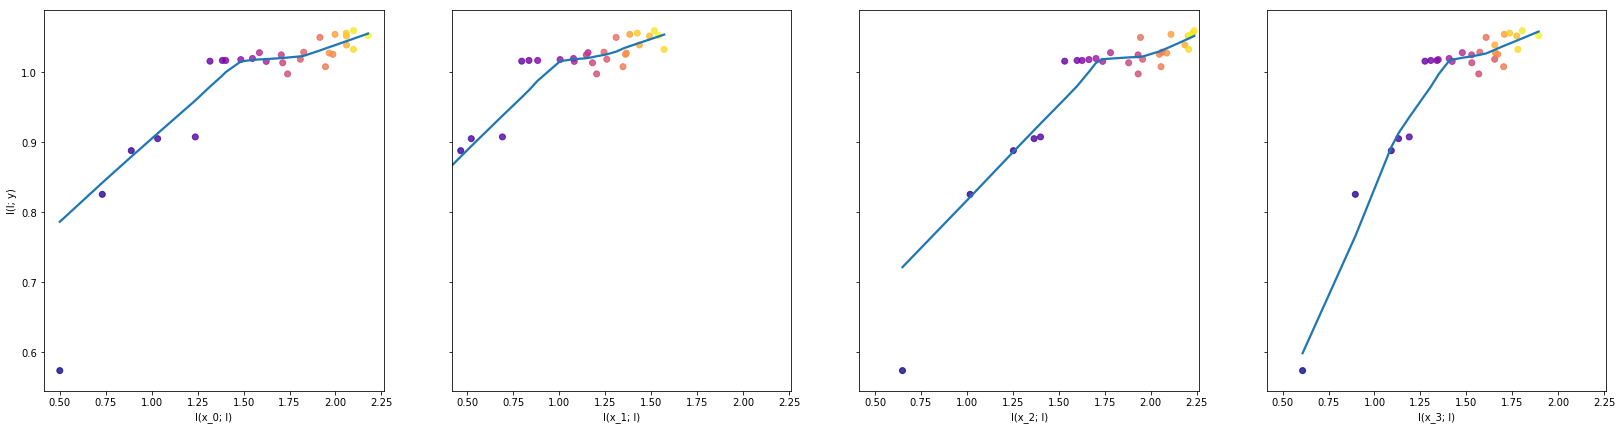

In [299]:
melted_df = df.melt(id_vars=['k', 'I(l; y)'], value_name='I(X; l)')

f, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(28,7))

for i in range(4):
    ddf = melted_df[melted_df['variable'] == 'I(x_{}; l)'.format(i)]
    ax = sns.regplot(x='I(X; l)', y="I(l; y)", ax=axes[i],
             data=ddf, lowess=True,
             scatter_kws={'color': None, 'c': ddf['k'], 'alpha': 0.8, 'cmap': 'plasma'},
             line_kws={'color': sns.color_palette()[0]})
    
    if i > 0:
        ax.set_ylabel("")
    ax.set_xlabel("I(x_{}; l)".format(i))
    

plt.show()

Let's plot all of the points together and see how that looks for that kink in the lowess regression

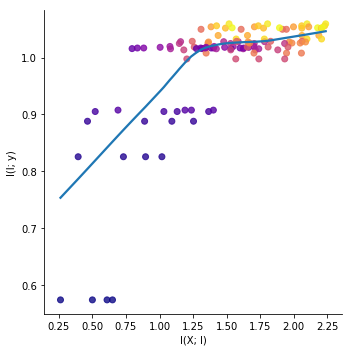

In [290]:
g = sns.lmplot(x='I(X; l)', y="I(l; y)",
            data=melted_df, lowess=True,
            scatter_kws={'color': None, 'c': melted_df['k'], 'alpha': 0.8, 'cmap': 'plasma'})

plt.show()

Neat huh?! We can see an obvious phase shift happening during clustering. Again this doesnt have to be clustering, this could be applied to much more including dimension reduction and feature selection. Below we print out the average mutual information between various features.

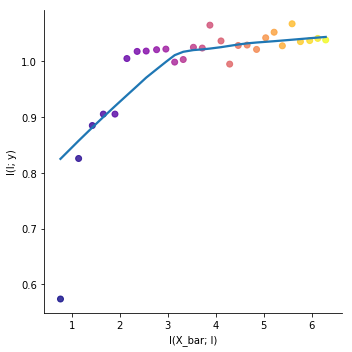

In [277]:
average_results = pd.DataFrame({'I(X_bar; l)': df.mean(axis=1), 'I(l; y)': df['I(l; y)'], 'k': df['k']})

sns.lmplot(x='I(X_bar; l)', y='I(l; y)', data=average_results, lowess=True,
           scatter_kws={'color': None, 'c': average_results['k'], 'alpha': 0.8, 'cmap': 'plasma'})

plt.show()

But at this point what exactly do we do with this information? we can visually see a tradeoff with K around 12. But can we do any better than this? For this we introduce the optimization function IB.

IB is defined as the information bottleneck and is I(X;T) - \beta I(T;Y). Beta is a lagrangian multiplier and generally you can think of this optimization problem as the following.

```
           max I(X;T)
subject to I(T;Y) = 0
```

What this intuitively means is that we want to capture as much information as possible between X and T while having no information between the representation layer and the output layer.

While we can't get into all the nuances of optimization theory and operations research we can generally look at this visually. You can see that in general the minimum of all of the Information Bottleneck functions is right around k = 13/14. This syncs up with our above graph using the LOWESS regression.

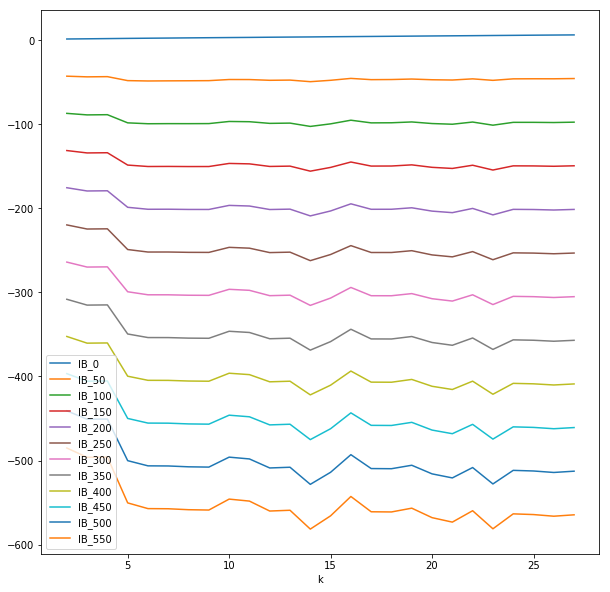

,IB_0,IB_50,IB_100,IB_150,IB_200,IB_250,IB_300,IB_350,IB_400,IB_450,IB_500,IB_550
k,,,,,,,,,,,,
2,1.429612,-42.802462,-87.034536,-131.266610,-175.498684,-219.730758,-263.962832,-308.194906,-352.426980,-396.659054,-440.891128,-485.123202
3,1.659217,-43.597179,-88.853575,-134.109970,-179.366366,-224.622762,-269.879157,-315.135553,-360.391949,-405.648344,-450.904740,-496.161136
4,1.902011,-43.354384,-88.610780,-133.867176,-179.123571,-224.379967,-269.636363,-314.892758,-360.149154,-405.405550,-450.661945,-495.918341
5,2.150634,-48.082467,-98.315567,-148.548668,-198.781769,-249.014870,-299.247970,-349.481071,-399.714172,-449.947273,-500.180373,-550.413474
6,2.364002,-48.507258,-99.378517,-150.249777,-201.121036,-251.992296,-302.863556,-353.734815,-404.606075,-455.477334,-506.348594,-557.219854
7,2.552349,-48.351464,-99.255276,-150.159088,-201.062900,-251.966713,-302.870525,-353.774337,-404.678149,-455.581961,-506.485774,-557.389586
8,2.769531,-48.256896,-99.283323,-150.309750,-201.336177,-252.362604,-303.389030,-354.415457,-405.441884,-456.468311,-507.494738,-558.521165
9,2.963389,-48.116514,-99.196417,-150.276320,-201.356224,-252.436127,-303.516030,-354.595933,-405.675837,-456.755740,-507.835643,-558.915546
10,3.146749,-46.767228,-96.681206,-146.595184,-196.509161,-246.423139,-296.337117,-346.251095,-396.165072,-446.079050,-495.993028,-545.907005


In [338]:
to_plot = pd.DataFrame(None, index=average_results['k'])

for beta in range(0, 600, 50):
    to_plot['IB_{}'.format(beta)] = (average_results['I(X_bar; l)'] - (beta * average_results['I(l; y)']))

to_plot.plot(figsize=(10,10))

plt.show()

to_plot

Taking this further we can find the argmax of each of these IB calculations. In practice most likely you would want to feed this through some sort of optimizer like basin hopping, genetic algorithms or the such. But for this we only have a few variables to look at.

In [339]:
to_plot.apply(pd.Series.argmin)

/home/hexgnu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/pandas/core/frame.py:4933: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  labels=labels)


IB_0       2
IB_50     14
IB_100    14
IB_150    14
IB_200    14
IB_250    14
IB_300    14
IB_350    14
IB_400    14
IB_450    14
IB_500    14
IB_550    14
dtype: int64

How would you go about actually calculating this minimum. To do that, you would take the partial derivatives of the lagrangian and find the values that are at zero. This isn't a trivial exercise but there are some interesting aspects which fall out of this namely what the critical value of the partial derivative of the lagrangian as well as the representation layer.

$$
IB(X,Y,T,Beta) = I(X;T) - \beta I(T;Y) \\
IB_x = \frac{\partial I(X;T)}{\partial X} = \frac{\partial H(X) - H(X|T)}{\partial x} \\
IB_y = - \beta \frac{\partial I(T;Y) } {\partial Y} = - \beta \frac{\partial H(T) - H(T|Y)}{\partial y}\\
IB_t = \frac{\partial I(X;T)}{\partial t} - \beta \frac{\partial I(T;Y)}{\partial t} \\
IB_{\beta} = -I(T;Y)
$$

What you see above is that $$IB_{\beta} = -I(T;Y) = 0$$. This would only happen if the classifier didn't share any information with the output layer.

Also another interesting aspect of the possible best ratio is $$IB_t = IB_x - IB_y$$. This states that $$IB_x = -IB_y$$ at the best value. Intuitively what this means is that we want mutual information between the input X and representation T to converge on it's max while being weighted against the mutual information of the output layer.

